# 1. Import and Install Dependencies

## 1.1 Install Dependencies

<b>Windows 10/11</b> setup:
<br>

1) Download and install Python 3.10.11:
<br>
https://www.python.org/downloads/release/python-31011/
<br>
`"add python.exe to PATH"` during installation.
<br>
Restart Windows

2) Create Virtual environment:
<br>
Open terminal in the project folder.
<br>
`python -m venv venv`

3) Activate venv:
<br>
`venv\Scripts\activate`

4) Update pip:
<br>
`python -m pip install --upgrade pip`

5) Install dependencies:
<br>
`pip install tensorflow-gpu<2.11 matplotlib==3.7.* librosa scikit-learn pandas numpy ipykernel seaborn pyartnet sounddevice`

6) Restart kernel (this notebook)


## 1.2 Training settings

In [37]:
# Audio parameters
AUDIO_CHUNK = 0.4 # seconds
SLICE_AUDIO = False
DATA_RANGE = 1.0
NUM_CHANNELS = 1
SAMPLE_RATE = 44100

# Mel spectrogram parameters
#N_FRAMES = None
N_MELS = 256
NFFT = 2048
FMAX = SAMPLE_RATE // 2
HOP_LENGTH = 512

# Training settings
EPOCHS = 10
BATCH_SIZE = 24

# Model settings
MODEL_ARCH = "defaultCNN"   # defaultCNN, customCNN1, mobilenetv3_nn, convnext_nn("tiny"/"base"), effnetv2_nn, dense_nn
MODEL_SPEC = None #"tiny"
MODEL_NAME = 'model.keras'
LABELER_NAME = 'labeler.joblib'

## 1.3 Load Dependencies

In [38]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
from classify_utilities import AudioProcessor
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import librosa
import numpy as np
import joblib
import random
from model import Deep_NN

In [39]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 2. Preprocess the Data

## 2.1 Define Paths to Files

In [40]:
DATASET_DIR = 'DATASET'
DATA_DIR = 'data'
TEST_DIR = 'TEST'
METADATA = "metadata.csv"
MODEL_PATH = os.path.join("MODEL", "model.keras")
LABELER_PATH = os.path.join("MODEL", "label_encoder.joblib")

# create folders if they don't exist
if not os.path.exists('MODEL'):
    os.makedirs('MODEL')
if not os.path.exists('data'):
    os.makedirs('data')
if not os.path.exists('TEST'):
    os.makedirs('TEST')
if not os.path.exists('DATASET'):
    os.makedirs('DATASET')

In [41]:
dataset_files = os.listdir('dataset')
model_files = os.listdir('model')
test_files = os.listdir('test')

print("Files in 'DATASET' folder:")
print(dataset_files)

print("Files in 'MODEL' folder:")
print(model_files)

print("Files in 'TEST' folder:")
print(test_files)

Files in 'DATASET' folder:
['attention', 'cheers', 'not', 'silence']
Files in 'MODEL' folder:
[]
Files in 'TEST' folder:
[]


In [42]:
audio_processor = AudioProcessor(sample_rate=SAMPLE_RATE, 
                                 n_mels = N_MELS,
                                 fmax = FMAX,
                                 n_fft = NFFT,
                                 hop_length = HOP_LENGTH, 
                                 audio_chunk = AUDIO_CHUNK,
                                 slice_audio = SLICE_AUDIO,
                                 data_range=DATA_RANGE
                                 )
                

## 2.2 Label Encoding

In [43]:
def encoder_fn(dataset_dir, labeler_dir, encoder, dump=False): 

    classes = os.listdir(dataset_dir)
    classes.sort()
    classes = np.array(classes).reshape(-1, 1)

    try:
        encoder.fit(classes)
    except IndexError:
        print("No classes found in dataset folder")
    if dump:
        joblib.dump(encoder, labeler_dir)

def idx2label(idx, encoder):
    idx_reshaped = np.array(idx).reshape(1, -1)
    return encoder.inverse_transform(idx_reshaped)[0][0]

def label2idx(label, encoder):
    label = np.array(label).reshape(-1, 1)
    return encoder.transform(label).toarray()[0]

In [44]:
oh_encoder = OneHotEncoder()

encoder_fn(dataset_dir=DATASET_DIR, labeler_dir=LABELER_PATH, encoder=oh_encoder)

In [45]:
random_label = random.choice(os.listdir(DATASET_DIR))
label2idx(random_label, oh_encoder)

array([0., 0., 0., 1.])

In [46]:
idx2label(label2idx(random_label, oh_encoder), oh_encoder)

'silence'

## 2.3 Exploratory data analysis

### Produce metadata dataframe

In [47]:
# Analyze dataset:
# List all the files in dictionare and subdictionaries.
metadata = []

for root, _, files in os.walk(DATASET_DIR):
    for i, file in enumerate(files):
        if file.endswith('.wav'):
            filename = os.path.join(root, file)
            label = os.path.basename(root)
            class_ = label2idx(label, oh_encoder)
            num_channels, sample_rate, bit_depth, avg_rms, length_in_seconds, length_in_frames = audio_processor.read_file_properties(filename)
            metadata.append({
                'filename': filename, 
                'label': label, 
                'class': class_,
                'num_channels': num_channels, 
                'sample_rate': sample_rate, 
                'bit_depth': bit_depth, 
                'avg_rms': avg_rms, 
                'length_in_seconds': length_in_seconds, 
                'length_in_frames': length_in_frames
            })

            print(f"Processing label: {label}, {i}th file named: {file}")
        else:
            print(f"Skipped {i} file. {file}")
            
metadata = pd.DataFrame(metadata)
metadata.to_csv(METADATA, index=False)

Skipped 0 file. attention_bim256_0001.png
Processing label: attention, 1th file named: attention_bim256_0001.wav
Skipped 2 file. attention_bim256_0002.png
Processing label: attention, 3th file named: attention_bim256_0002.wav
Skipped 4 file. attention_bim256_0003.png
Processing label: attention, 5th file named: attention_bim256_0003.wav
Skipped 6 file. attention_bim256_0004.png
Processing label: attention, 7th file named: attention_bim256_0004.wav
Skipped 8 file. attention_bim256_0005.png
Processing label: attention, 9th file named: attention_bim256_0005.wav
Skipped 10 file. attention_bim256_0006.png
Processing label: attention, 11th file named: attention_bim256_0006.wav
Skipped 12 file. attention_bim256_0007.png
Processing label: attention, 13th file named: attention_bim256_0007.wav
Skipped 14 file. attention_bim256_0008.png
Processing label: attention, 15th file named: attention_bim256_0008.wav
Skipped 16 file. attention_bim256_0009.png
Processing label: attention, 17th file named: a

Processing label: attention, 673th file named: attention_bim256_0337.wav
Skipped 674 file. attention_bim256_0338.png
Processing label: attention, 675th file named: attention_bim256_0338.wav
Skipped 676 file. attention_bim256_0339.png
Processing label: attention, 677th file named: attention_bim256_0339.wav
Skipped 678 file. attention_bim256_0340.png
Processing label: attention, 679th file named: attention_bim256_0340.wav
Skipped 680 file. attention_bim256_0341.png
Processing label: attention, 681th file named: attention_bim256_0341.wav
Skipped 682 file. attention_bim256_0342.png
Processing label: attention, 683th file named: attention_bim256_0342.wav
Skipped 684 file. attention_bim256_0343.png
Processing label: attention, 685th file named: attention_bim256_0343.wav
Skipped 686 file. attention_bim256_0344.png
Processing label: attention, 687th file named: attention_bim256_0344.wav
Skipped 688 file. attention_bim256_0345.png
Processing label: attention, 689th file named: attention_bim256_

### Observe the data

In [48]:
metadata.head()

filename      label  \
0  DATASET\attention\attention_bim256_0001.wav  attention   
1  DATASET\attention\attention_bim256_0002.wav  attention   
2  DATASET\attention\attention_bim256_0003.wav  attention   
3  DATASET\attention\attention_bim256_0004.wav  attention   
4  DATASET\attention\attention_bim256_0005.wav  attention   

                  class  num_channels  sample_rate  bit_depth   avg_rms  \
0  [1.0, 0.0, 0.0, 0.0]             1        44100         16  0.052868   
1  [1.0, 0.0, 0.0, 0.0]             1        44100         16  0.105407   
2  [1.0, 0.0, 0.0, 0.0]             1        44100         16  0.118205   
3  [1.0, 0.0, 0.0, 0.0]             1        44100         16  0.038741   
4  [1.0, 0.0, 0.0, 0.0]             1        44100         16  0.054758   

   length_in_seconds  length_in_frames  
0           0.397982             17551  
1           0.397982             17551  
2           0.397982             17551  
3           0.397982             17551  
4           0.397982             17551

### class balance

In [49]:
print(metadata["label"].value_counts())

label
cheers       8465
attention    5796
not          2417
silence      1537
Name: count, dtype: int64


### plot class waveforms

DATASET\attention\attention_bim256_0001.wav
DATASET\cheers\cheers1_h_600amp_0001.wav
DATASET\not\combCafeKlatsch22_0001.wav
DATASET\silence\ambient_0001.wav


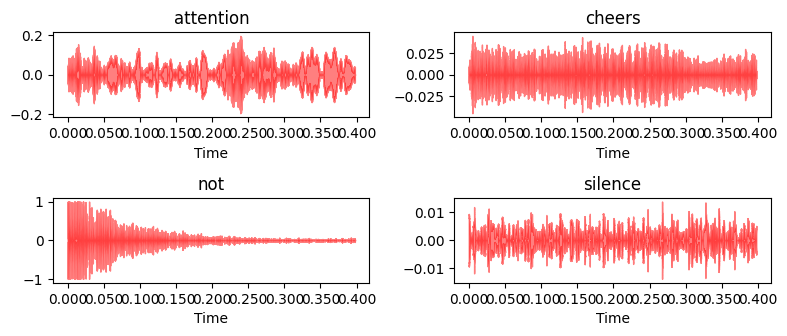

In [50]:
labels = metadata["label"].unique()

fig = plt.figure(figsize=(8,8))

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, label in enumerate(labels):
    filtered_df = metadata[metadata["label"] == label]
    slice_file_name = filtered_df["filename"].iloc[0]
    fold = filtered_df["label"].iloc[0]
    fig.add_subplot(5, 2, i+1)
    plt.title(label)
    data, sr = librosa.load(os.path.join(slice_file_name), sr=SAMPLE_RATE, mono=False)
    librosa.display.waveshow(y = data, sr=sr, color="r", alpha=0.5, label='Harmonic')
    print(slice_file_name)
     
plt.tight_layout()  # This will adjust spacing between subplots to prevent overlap
plt.show()  # This will display the plot

In [51]:
# num of channels 
print("Channels: ")
print(metadata.num_channels.value_counts(normalize=True))
print("\n")

# sample rates 
print("Sample Rates: ")
print(metadata.sample_rate.value_counts(normalize=True))
print("\n")

# bit depth
print("Bit Depth: ")
print(metadata.bit_depth.value_counts(normalize=True))
print("\n")

# length in samples
print("Samples: ")
print(metadata.length_in_frames.describe())
print("\n")

# length in seconds
print("Length (s): ")
print(metadata.length_in_seconds.describe())

# RMS
print(metadata.avg_rms.describe())


Channels: 
num_channels
1    1.0
Name: proportion, dtype: float64


Sample Rates: 
sample_rate
44100    1.0
Name: proportion, dtype: float64


Bit Depth: 
bit_depth
16    1.0
Name: proportion, dtype: float64


Samples: 
count    18215.000000
mean     17540.846390
std         33.398409
min      17408.000000
25%      17551.000000
50%      17551.000000
75%      17551.000000
max      17551.000000
Name: length_in_frames, dtype: float64


Length (s): 
count    18215.000000
mean         0.397752
std          0.000757
min          0.394739
25%          0.397982
50%          0.397982
75%          0.397982
max          0.397982
Name: length_in_seconds, dtype: float64
count    18215.000000
mean         0.032610
std          0.043642
min          0.000296
25%          0.012806
50%          0.021754
75%          0.036536
max          0.890025
Name: avg_rms, dtype: float64


## 2.4 Audio Preprocessing:

### Test audio preprocessing methods
-   Librosa -> 
        SR: 22050
        channel: 1
    trim/pad ->
        length: 3s (3x22050)
    spectrogram ->
        mel-spectrogram / spectrogram / MFCC
    post-process ->
        to Db (log scale, more apparent patterns)
        abs 
    normalize ->
        
        


audio_file shape (17551,) - (frames, channels)
audio_file sample rate 44100 Hz
Spectrogram shape (256, 35) - (mels/frequency, frames/time)
spectrogram min: 0.0 spectrogram max: 1.0, average: 0.39077311754226685
spectrogram dtype: float32
audio dtype: float32 - bit depth


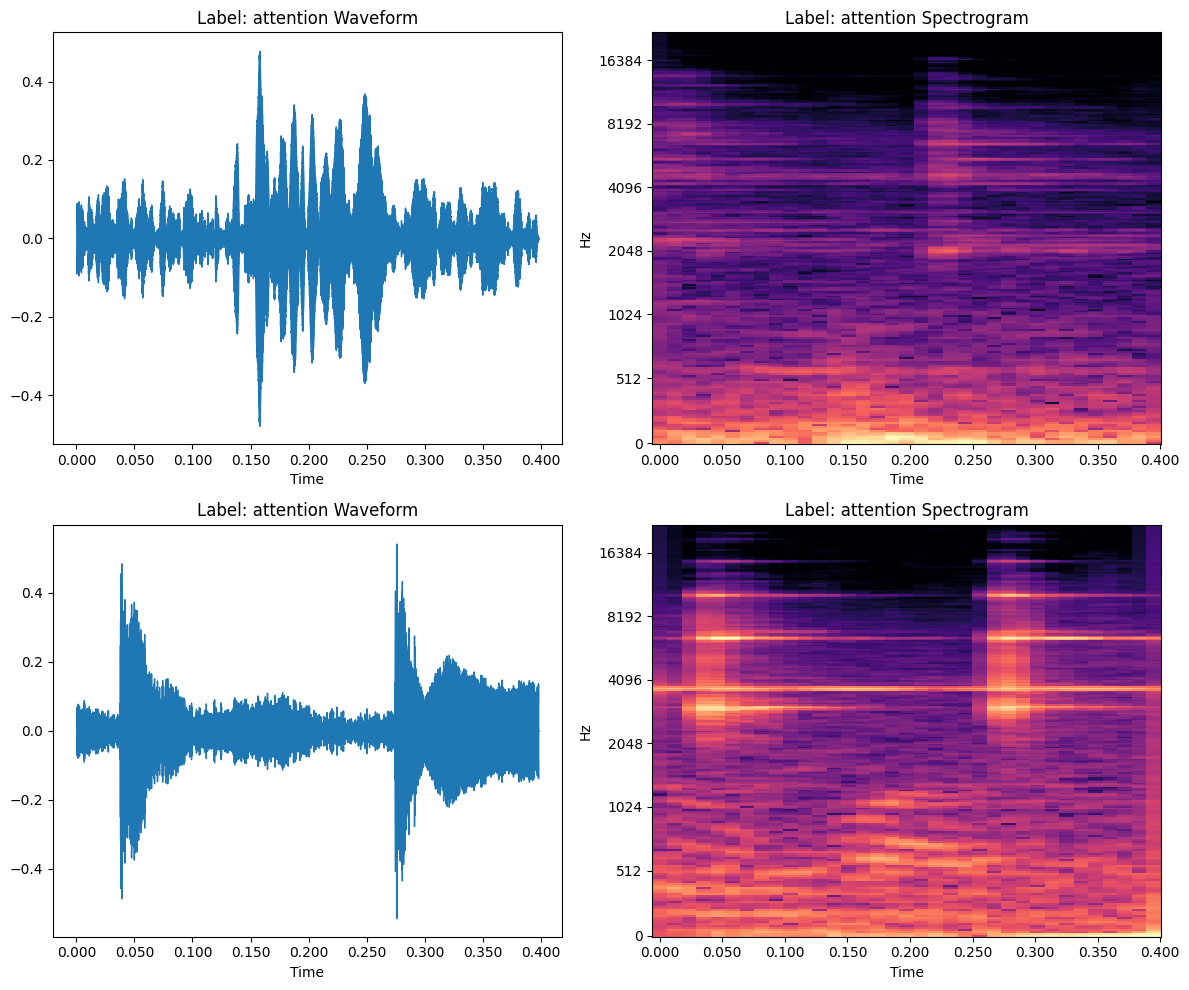

In [52]:
# Test the Fourier transform
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
rows = metadata.iloc[[34, 1280]]

#rows = metadata.sample(2)
slice_length = AUDIO_CHUNK
samples_show = len(rows)
pass_ = 0

fig, axes = plt.subplots(nrows=samples_show, ncols=2, figsize=(12, samples_show* 5))

for i, row in rows.iterrows():    
    if pass_ > samples_show:
        break
    audio_file, librosa_sample_rate = librosa.load(row["filename"], sr=SAMPLE_RATE)
    if SLICE_AUDIO: 
        print(slice)
        sample_length = slice_length * librosa_sample_rate

        audio_file = audio_file[:sample_length]
        if len(audio_file) < sample_length:
            audio_file = np.pad(audio_file, (0, sample_length - len(audio_file)), constant_values=0)

    #spectrogram = audio_processor(data = audio_file)
    spectrogram = librosa.feature.melspectrogram(y=audio_file, sr=librosa_sample_rate, n_mels=256, fmax = FMAX, n_fft=2048, hop_length=512)
    spectrogram = (librosa.power_to_db(spectrogram, ref=np.max))

    # general scale normalization with min-max
    #min_db, max_db = -60, 80
    #spectrogram = np.clip((spectrogram - min_db) / (max_db - min_db), 0, 1)
    #spectrogram = (spectrogram - min_db) / (max_db - min_db)

    # Min-Max normalization
    spectrogram = (spectrogram - spectrogram.min()) / (spectrogram.max() - spectrogram.min())

        # wave Plot
    axes[pass_, 0].set_title(f"Label: {row['label']} Waveform")
    librosa.display.waveshow(audio_file, sr=librosa_sample_rate, ax=axes[pass_, 0])
    # spectrogram plot
    axes[pass_, 1].set_title(f"Label: {row['label']} Spectrogram")
    img = librosa.display.specshow(spectrogram, sr=librosa_sample_rate, x_axis='time', y_axis='mel', ax=axes[pass_, 1])
    pass_ += 1


print(f"audio_file shape {audio_file.shape} - (frames, channels)")
print(f"audio_file sample rate {librosa_sample_rate} Hz")
print(f"Spectrogram shape {spectrogram.shape} - (mels/frequency, frames/time)")
print(f"spectrogram min: {spectrogram.min()} spectrogram max: {spectrogram.max()}, average: {spectrogram.mean()}")
print(f"spectrogram dtype: {spectrogram.dtype}")
print(f"audio dtype: {audio_file.dtype} - bit depth")

#fig.colorbar(img, ax=axes[:, 0], format='%+2.0f dB')
plt.tight_layout()
plt.show()

## 3 Prepare Dataset

## 3.1 Extract features and labels into dataframe

In [53]:
# Preprocessing function

def extract_features(row):
    
    class_label = row["class"]
    
    audio_file,_ = librosa.load(row["filename"], sr=SAMPLE_RATE)

    spectrogram = audio_processor(
        data = audio_file, data_range = 255) # 1 or 255 range
    
    shape = spectrogram.shape

    return spectrogram, class_label, shape

In [54]:
#In each iteration of the loop, the variable index is assigned the index value of the current row, and the variable row is assigned the data of the current row (as a Series object).
features = []

for index, row in metadata.iterrows():
    features.append(extract_features(row))
    print(f"Processed {index} file. {row['filename']}")

   
dataset_df = pd.DataFrame(features, columns=["features", "class_label", "shape"])
print('Finished feature extraction from ', len(dataset_df), ' files') 
N_FRAMES = dataset_df["shape"].iloc[0][0]
print(f"Number of frames: {N_FRAMES}")

Processed 0 file. DATASET\attention\attention_bim256_0001.wav
Processed 1 file. DATASET\attention\attention_bim256_0002.wav
Processed 2 file. DATASET\attention\attention_bim256_0003.wav
Processed 3 file. DATASET\attention\attention_bim256_0004.wav
Processed 4 file. DATASET\attention\attention_bim256_0005.wav
Processed 5 file. DATASET\attention\attention_bim256_0006.wav
Processed 6 file. DATASET\attention\attention_bim256_0007.wav
Processed 7 file. DATASET\attention\attention_bim256_0008.wav
Processed 8 file. DATASET\attention\attention_bim256_0009.wav


Processed 9 file. DATASET\attention\attention_bim256_0010.wav
Processed 10 file. DATASET\attention\attention_bim256_0011.wav
Processed 11 file. DATASET\attention\attention_bim256_0012.wav
Processed 12 file. DATASET\attention\attention_bim256_0013.wav
Processed 13 file. DATASET\attention\attention_bim256_0014.wav
Processed 14 file. DATASET\attention\attention_bim256_0015.wav
Processed 15 file. DATASET\attention\attention_bim256_0016.wav
Processed 16 file. DATASET\attention\attention_bim256_0017.wav
Processed 17 file. DATASET\attention\attention_bim256_0018.wav
Processed 18 file. DATASET\attention\attention_bim256_0019.wav
Processed 19 file. DATASET\attention\attention_bim256_0020.wav
Processed 20 file. DATASET\attention\attention_bim256_0021.wav
Processed 21 file. DATASET\attention\attention_bim256_0022.wav
Processed 22 file. DATASET\attention\attention_bim256_0023.wav
Processed 23 file. DATASET\attention\attention_bim256_0024.wav
Processed 24 file. DATASET\attention\attention_bim256_00

### Our feature data stats:

In [55]:
dataset_df.head()

features           class_label  \
0  [[208.46309, 213.5288, 222.22603, 219.53766, 2...  [1.0, 0.0, 0.0, 0.0]   
1  [[198.3176, 198.21901, 201.08925, 198.43124, 1...  [1.0, 0.0, 0.0, 0.0]   
2  [[219.11269, 214.70287, 204.38972, 189.78198, ...  [1.0, 0.0, 0.0, 0.0]   
3  [[226.76291, 225.38838, 225.80724, 216.31381, ...  [1.0, 0.0, 0.0, 0.0]   
4  [[249.86758, 247.11758, 243.92093, 227.86552, ...  [1.0, 0.0, 0.0, 0.0]   

       shape  
0  (35, 256)  
1  (35, 256)  
2  (35, 256)  
3  (35, 256)  
4  (35, 256)

In [56]:
print(f"Dataset shape: {dataset_df['shape'].value_counts()}")
print(f"Data values Min: {dataset_df['features'].apply(lambda x: x.min()).min()}, Max: {dataset_df['features'].apply(lambda x: x.max()).max()}, dtype: {dataset_df['features'].apply(lambda x: x.dtype).unique()} \nAverage: {dataset_df['features'].apply(lambda x: x.mean()).mean()}, Median: {dataset_df['features'].apply(lambda x: x.mean()).median()}")
print(f"Number of time frames N_FRAMES: {N_FRAMES}")

Dataset shape: shape
(35, 256)    18215
Name: count, dtype: int64
Data values Min: 0.0, Max: 255.0, dtype: [dtype('float32')] 
Average: 107.00101470947266, Median: 108.07487487792969
Number of time frames N_FRAMES: 35


## 3.2 Train Test Split

In [57]:
X = np.array(dataset_df.features.tolist())
y = np.array(dataset_df.class_label.tolist())
X.shape

(18215, 35, 256)

In [58]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state = 42)

### Double check prepared dataset

In [59]:
print(f"randomm feature example: {X[0]} and label: {y[0]}")

randomm feature example: [[208.46309   213.5288    222.22603   ...  26.804115   25.818283
   22.889414 ]
 [232.12798   233.24432   237.94333   ...  13.562804   12.357253
   11.666676 ]
 [216.1714    220.96237   229.44716   ...   0.          0.
    2.3474836]
 ...
 [254.80962   250.96756   243.62148   ...   0.          0.
    0.       ]
 [248.8282    244.44986   234.32257   ...  12.106844    9.855492
    9.290909 ]
 [236.60323   232.34595   222.90686   ...  35.205444   36.33383
   35.71509  ]] and label: [1. 0. 0. 0.]


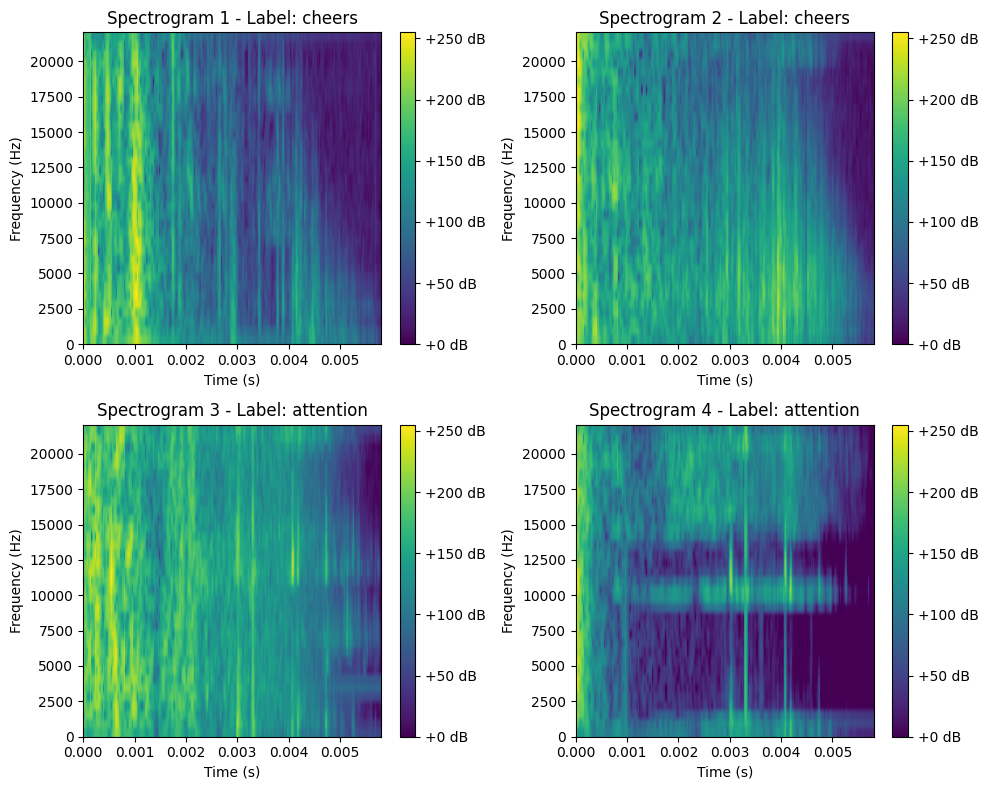

In [60]:
selected_rows = dataset_df.sample(n=4)

# Create subplots with 2 rows and 2 columns
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Iterate over the subplots and fill each with a spectrogram
for i, (idx, row) in enumerate(selected_rows.iterrows()):
    spectrogram = row['features']
    label = row['class_label']
    ax = axs[i // 2, i % 2]  # Calculate the subplot position
    im = ax.imshow(spectrogram, aspect='auto', origin='lower', cmap='viridis',
                   extent=[0, spectrogram.shape[1] / SAMPLE_RATE, 0, SAMPLE_RATE / 2])
    ax.set_title(f'Spectrogram {i+1} - Label: {idx2label(label, oh_encoder)}')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    fig.colorbar(im, ax=ax, format='%+2.0f dB')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

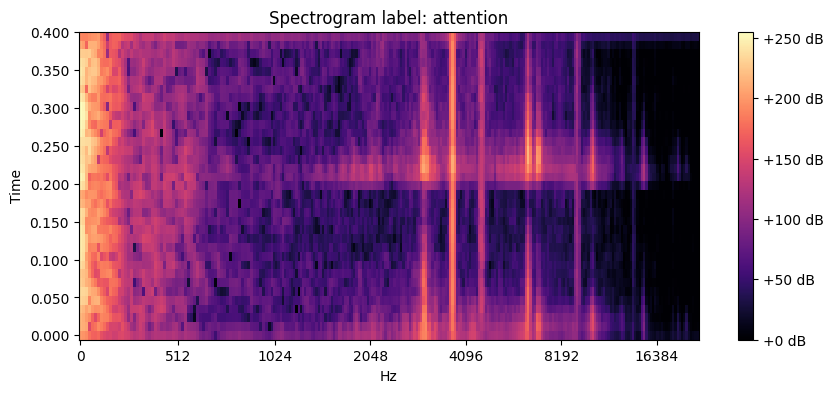

In [61]:
# Get the random feature array
sample_no = 42
sample_f = dataset_df.iloc[sample_no]["features"]
sample_l = dataset_df.iloc[sample_no]["class_label"]
# Plot the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(sample_f, sr=SAMPLE_RATE, x_axis='mel', y_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram label: ' + idx2label(sample_l, oh_encoder))
plt.show()

## 3.3 Reshape sets for NN input layer

In [62]:
x_train = x_train.reshape(x_train.shape[0], N_FRAMES, N_MELS, NUM_CHANNELS)
x_test = x_test.reshape(x_test.shape[0], N_FRAMES, N_MELS, NUM_CHANNELS)

num_labels = y.shape[1]
print(f"num_labels: {num_labels}")
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")

num_labels: 4
x_train shape: (14572, 35, 256, 1)
y_train shape: (14572, 4)


# 4. Build Deep Learning Model

## 4.1 Load deep neural net

In [63]:
# load a class with various model archietectures to test
modelClass = Deep_NN(num_classes=num_labels, dim1 = N_FRAMES, dim2 = N_MELS, dim3 = NUM_CHANNELS)

In [64]:
# Choose model architecture to train on
model = getattr(modelClass, MODEL_ARCH)(MODEL_SPEC)

#model = modelClass.defaultCNN()

TypeError: Deep_NN.defaultCNN() takes 1 positional argument but 2 were given

## 4.2 Compile Sequential Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(
    optimizer=optimizer, 
    loss='CategoricalCrossentropy', 
    metrics=['accuracy', Precision(), Recall()]
    )

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 8, 64, 96)   1824        ['input_1[0][0]']                
 )                                                                                                
                                                                                                  
 convnext_tiny_stage_0_block_0_  (None, 8, 64, 96)   4800        ['convnext_tiny_stem[0][0]']     
 depthwise_conv (Conv2D)                                                                      

## 4.3 Fit Model, View Loss and KPI Plots

In [ ]:
hist = model.fit(x_train, 
                 y_train, 
                 epochs=EPOCHS, 
                 validation_data=(x_test, y_test), 
                 batch_size=BATCH_SIZE
                 )

Epoch 1/10
608/608 [==============================] - 836s 1s/step - loss: 8.6608 - accuracy: 0.4627 - precision: 0.4627 - recall: 0.4627 - val_loss: 8.4949 - val_accuracy: 0.4730 - val_precision: 0.4730 - val_recall: 0.4730
Epoch 2/10
608/608 [==============================] - 803s 1s/step - loss: 8.6608 - accuracy: 0.4627 - precision: 0.4627 - recall: 0.4627 - val_loss: 8.4949 - val_accuracy: 0.4730 - val_precision: 0.4730 - val_recall: 0.4730
Epoch 3/10
289/608 [=============>................] - ETA: 6:33 - loss: 8.7004 - accuracy: 0.4602 - precision: 0.4602 - recall: 0.4602

KeyboardInterrupt: 

In [ ]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

In [ ]:
plt.title('Accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

In [ ]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 5. Make a Prediction on a Single Clip

## 5.1 Make a Prediction, Evaluate

In [ ]:
predictions = model.predict(x_test)

In [ ]:
print(idx2label(predictions[19]))
print(idx2label(y_test[19]))
print(f"input default shape: {x_test[1].shape}")
print(f"reshaped input feature shape: {np.expand_dims((x_test[21]), axis=0).shape}")

In [ ]:
prediction = model.predict(np.expand_dims((x_test[1]), axis=0))
print(prediction)
print(idx2label(prediction))

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=1)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=1)
print("Testing Accuracy: ", score[1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'predictions' is an array of predicted probabilities for each class
# And 'y_test' is an array of actual class labels

# Convert predicted probabilities to class labels
predicted_labels = [idx2label(pred) for pred in predictions]
y_test_labels = [idx2label(pred) for pred in y_test]

# Create the confusion matrix
cm = confusion_matrix(y_test_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
score = model.evaluate(x_test, y_test, verbose=1)

plt.title(f"Confusion Matrix (Accuracy: {score[1]})")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 5.2 Save Model

In [ ]:
model.save(MODEL_PATH)

# 6. Inference 

## 6.1 Load local model and labels

In [ ]:
# Load the encoder in the inference environment
loaded_encoder = joblib.load(LABELER_PATH)
model = tf.keras.models.load_model(MODEL_PATH)

## 6.1 Inference on loacl files

In [ ]:
audio_files = os.listdir(TEST_DIR)
random.shuffle(audio_files)

try:
    print(audio_files[1])
    audio_labels = [os.path.splitext(file)[0] for file in audio_files]
except IndexError:
    print("No files in test directory")

In [ ]:
for file in audio_files:
    path = os.path.join(TEST_DIR, file)
    print(path)
    data, _ = librosa.load(path, sr=SAMPLE_RATE)
    prediction_feature = audio_processor(
            data = data
        )
    
    # Reshape to match model input shape
    prediction_feature = prediction_feature.reshape(1, N_FRAMES, N_MELS, NUM_CHANNELS)
    predicted_class = idx2label(model.predict(prediction_feature)) 
    print("The predicted class is:", predicted_class, '\n') 

## 6.2 Real-time inference

## run "run.py"

In [ ]:
from inference_class import SoundClassificationService

def main():

    config = {
        "model_path": MODEL_PATH,
        "labels_path": LABELER_PATH,
        
        "sample_rate": SAMPLE_RATE,
        "num_channels": NUM_CHANNELS,
        "audio_chunk": AUDIO_CHUNK,
        
        "num_mels": N_MELS,
        "n_fft": NFFT,
        "fmax": FMAX,
        "hop_length": HOP_LENGTH,
        
        "confidence_threshold": 0.5,
        "listening_hop_length": 0.6,
        "device": "cpu"

    }

    service = SoundClassificationService.get_instance(config)
    service.listen_and_predict(duration=AUDIO_CHUNK, overlap=0.5)


if __name__ == "__main__":
    main()